# Search ORNL DAAC for lidar datasets

We will use NASA's Earthdata [CMR API](https://cmr.earthdata.nasa.gov/search) to search for lidar dataset. CMR catalogs metadata records of NASA Earth Science data and make them available for easy programmatic access.

In [82]:
import requests 
import pandas as pd
from shapely.geometry import box
import datetime as dt 

# search terms
freetxt='lidar'

# brazil bounding box
bound = (-73.9872354804, -33.7683777809, -34.7299934555, 5.24448639569) 

# time bound
dt_format = '%Y-%m-%dT%H:%M:%SZ'
start_date = dt.datetime(2010, 1, 1) # specify your own start date
end_date = dt.datetime(2018, 1, 1)  # specify your end start date
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

cmrurl='https://cmr.earthdata.nasa.gov/search/collections.json?data_center=ORNL_DAAC&page_size=1000' # CMR API base url for ORNL DAAC Data
txtsearch = cmrurl + '&keyword=' + freetxt + \
                '&bounding_box[]=' + ','.join(map(str, bound)) + \
                '&temporal=' + temporal_str
response = requests.get(txtsearch)
collections = response.json()['feed']['entry']
datasets = []
for c in collections:
    dataset_id = c['dataset_id']
    concept_id = c['id']
    processing_level_id = c['processing_level_id']
    time_start = c['time_start']
    time_end = c['time_end']
    a = tuple(float(s) for s in c['boxes'][0].split (" "))
    boxes = box(a[1], a[0], a[3], a[2])
    
    # get dataset doi
    for j in c['links']:
        links = j['href']
        if links.startswith('https://doi.org/'):
            doi = j['href']
    datasets.append([dataset_id, concept_id, doi, processing_level_id, time_start, time_end, boxes])
    
cmrpd = pd.DataFrame(datasets, columns=["dataset_id", "concept_id", "DOI", "proc_level", "time_start", "time_end", "boxes"])

Now, let's list the datasets below.

In [83]:
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

cmrpd.style.format({'DOI': make_clickable})

,dataset_id,concept_id,DOI,proc_level,time_start,time_end,boxes
0,"LiDAR Surveys over Selected Forest Research Sites, Brazilian Amazon, 2008-2018",C1680861772-ORNL_DAAC,https://doi.org/10.3334/ORNLDAAC/1644,1B,2008-01-01T00:00:00.000Z,2018-12-31T23:59:59.000Z,"POLYGON ((-39.06 -26.7, -39.06 -1.58, -68.3 -1.58, -68.3 -26.7, -39.06 -26.7))"
1,"CMS: LiDAR Data for Forested Areas in Paragominas, Para, Brazil, 2012-2014",C1000000761-ORNL_DAAC,https://doi.org/10.3334/ORNLDAAC/1302,3,2012-07-27T00:00:00.000Z,2014-12-27T23:59:59.000Z,"POLYGON ((-46.79 -3.77, -46.79 -2.55, -48.5 -2.55, -48.5 -3.77, -46.79 -3.77))"
2,"LiDAR and PALSAR-Derived Forest Aboveground Biomass, Paragominas, Para, Brazil, 2012",C1616834124-ORNL_DAAC,https://doi.org/10.3334/ORNLDAAC/1648,3,2012-01-01T00:00:00.000Z,2013-12-31T23:59:59.000Z,"POLYGON ((-46 -4.01, -46 -2, -49 -2, -49 -4.01, -46 -4.01))"
3,"Aboveground Biomass Change for Amazon Basin, Mexico, and Pantropical Belt, 2003-2016",C2015954203-ORNL_DAAC,https://doi.org/10.3334/ORNLDAAC/1824,3,2003-01-01T00:00:00.000Z,2016-12-31T23:59:59.000Z,"POLYGON ((180 -30, 180 40, -180 40, -180 -30, 180 -30))"
4,"Tree Inventory and Biometry Measurements, Tapajos National Forest, Para, Brazil, 2010",C1457055048-ORNL_DAAC,https://doi.org/10.3334/ORNLDAAC/1552,2,2010-08-31T00:00:00.000Z,2010-09-16T23:59:59.000Z,"POLYGON ((-54.95 -3.15, -54.95 -2.86, -54.99 -2.86, -54.99 -3.15, -54.95 -3.15))"


Let's say we are interested in above ground biomass.

0    Annotation(-53.68, -14.14, 'C1680861772-ORNL_D...
1    Annotation(-47.645, -3.16, 'C1000000761-ORNL_D...
2    Annotation(-47.5, -3.005, 'C1616834124-ORNL_DA...
3           Annotation(-0, 5, 'C2015954203-ORNL_DAAC')
4    Annotation(-54.97, -3.005, 'C1457055048-ORNL_D...
dtype: object

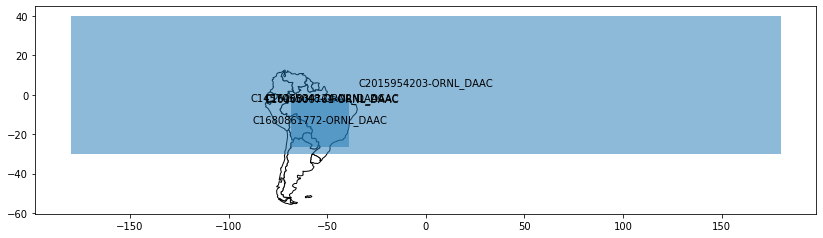

In [87]:
import geopandas
gdf = geopandas.GeoDataFrame(cmrpd, geometry=cmrpd.boxes)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world[world.continent == 'South America'].plot(color='white', edgecolor='black', figsize  = (14, 14))
ax= gdf.plot(ax=base, alpha=0.5)
gdf.apply(lambda x: ax.annotate(s=x.concept_id, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)


TypeError: box() missing 3 required positional arguments: 'miny', 'maxx', and 'maxy'

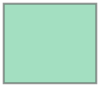

In [81]:
box(a[1], a[0], a[3], a[2])